<table align="center" width=150%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                    <b> Assignment 3: Emotion Classification Based on Social Media Data <br>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [1]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


In [2]:
!pip install text_hammer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.38 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [3]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/NLP/

/content/drive/MyDrive/NLP


In [102]:
import pandas as pd
import numpy as np
import random

import text_hammer as th
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFBertModel, TFDistilBertModel, TFRobertaModel
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score

from transformers import BertTokenizerFast, RobertaTokenizerFast, DistilBertTokenizerFast
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, Input

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

###Loading the Hugging face emotion datasets - train, test and validation

In [7]:
train_df = pd.read_parquet("train.parquet")
validation_df = pd.read_parquet("validation.parquet")
test_df = pd.read_parquet("test.parquet")

In [8]:
print("Shape of Train dataset:", train_df.shape)
print("Shape of Validation dataset:", validation_df.shape)
print("Shape of Test dataset:", test_df.shape)

Shape of Train dataset: (3257, 2)
Shape of Validation dataset: (374, 2)
Shape of Test dataset: (1421, 2)


In [9]:
train_df.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [10]:
validation_df.head()

,text,label
0,"@user @user Oh, hidden revenge and anger...I r...",0
1,if not then #teamchristine bc all tana has don...,0
2,Hey @user #Fields in #skibbereen give your onl...,0
3,Why have #Emmerdale had to rob #robron of havi...,0
4,@user I would like to hear a podcast of you go...,0


In [11]:
test_df.head()

,text,label
0,#Deppression is real. Partners w/ #depressed p...,3
1,@user Interesting choice of words... Are you c...,0
2,My visit to hospital for care triggered #traum...,3
3,@user Welcome to #MPSVT! We are delighted to h...,1
4,What makes you feel #joyful?,1


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [13]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    374 non-null    object
 1   label   374 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1421 non-null   object
 1   label   1421 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.3+ KB


####Converting label into categorical type for visualization

In [15]:
train_df["label"] = train_df["label"].astype(object)
validation_df["label"] = validation_df["label"].astype(object)
test_df["label"] = test_df["label"].astype(object)

In [16]:
train_df["label"].value_counts()

label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64

In [17]:
validation_df["label"].value_counts()

label
0    160
1     97
3     89
2     28
Name: count, dtype: int64

In [18]:
test_df["label"].value_counts()

label
0    558
3    382
1    358
2    123
Name: count, dtype: int64

####Distribution of Target Labels in train, validation and test datasets

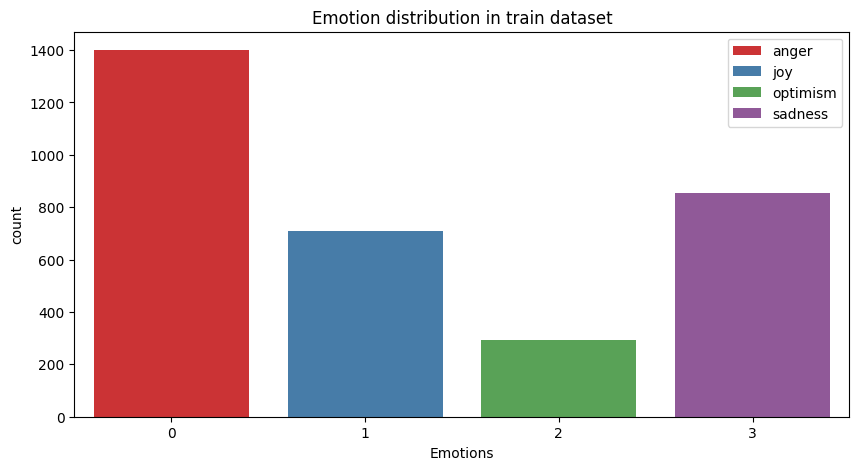

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x=train_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in train dataset")
plt.xlabel("Emotions")
plt.show()

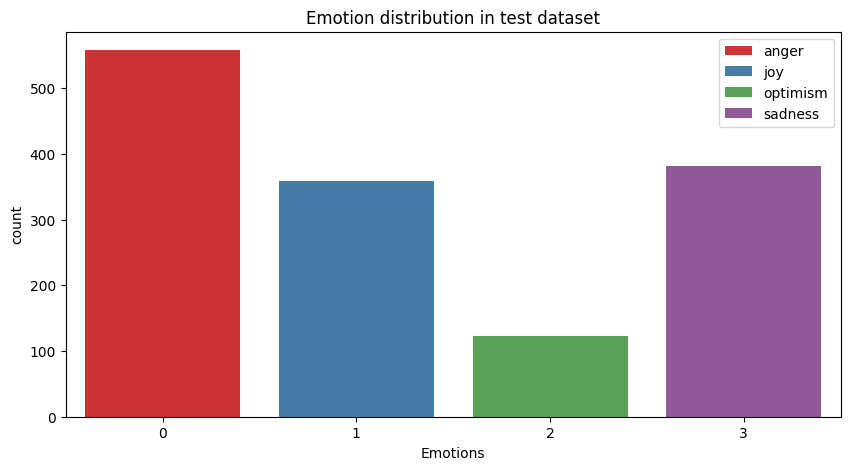

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x=test_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in test dataset")
plt.xlabel("Emotions")
plt.show()

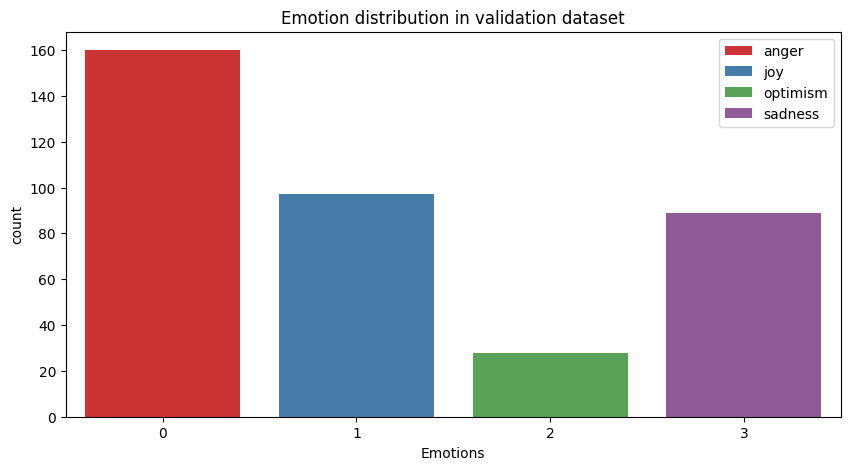

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x=validation_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in validation dataset")
plt.xlabel("Emotions")
plt.show()

#####Analysing the maximum word length of the tweets before basic text cleaning

In [22]:
train_df['word_len'] = train_df['text'].apply(lambda x:len(x.split()))
validation_df['word_len'] = validation_df['text'].apply(lambda x:len(x.split()))
test_df['word_len'] = test_df['text'].apply(lambda x:len(x.split()))

In [23]:
print("Maximum tweet length in train dataset:", train_df['word_len'].max())
print("Maximum tweet length in test dataset:", test_df['word_len'].max())
print("Maximum tweet length in validation dataset:", validation_df['word_len'].max())

Maximum tweet length in train dataset: 33
Maximum tweet length in test dataset: 36
Maximum tweet length in validation dataset: 32


####Text preprocessing/cleaning
1.   Changing to lower case
2.   Exapnding words like you're to you are, i'm to I am
3.   Removing emails
4.   Removing html tags
5.   Removing special characters like @, #, % etc
6.   Removing accented characters like u^, `a etc









In [24]:
def text_cleaning(df):
  df["text"] = df["text"].progress_apply(lambda x:str(x).lower())
  df["text"] = df["text"].progress_apply(lambda x: th.cont_exp(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_emails(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_html_tags(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_special_chars(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_accented_chars(x))
  return(df)

In [25]:
train_df_cleaned = text_cleaning(train_df.copy())
test_df_cleaned = text_cleaning(test_df.copy())
validation_df_cleaned = text_cleaning(validation_df.copy())

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

In [26]:
original_train = train_df["text"][:5]
cleaned_train = train_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_train, cleaned=cleaned_train)).reset_index(drop=True)

,original,cleaned
0,“Worry is a down payment on a problem you may ...,worry is a down payment on a problem you may n...
1,My roommate: it's okay that we can't spell bec...,my roommate it is okay that we cannot spell be...
2,No but that's so cute. Atsu was probably shy a...,no but that is so cute atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...,rooneys fucking untouchable is not he been fuc...
4,it's pretty depressing when u hit pan on ur fa...,it is pretty depressing when you hit pan on yo...


In [27]:
original_test = test_df["text"][:5]
cleaned_test = test_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_test, cleaned=cleaned_test)).reset_index(drop=True)

,original,cleaned
0,#Deppression is real. Partners w/ #depressed p...,deppression is real partners w depressed peopl...
1,@user Interesting choice of words... Are you c...,user interesting choice of words are you confi...
2,My visit to hospital for care triggered #traum...,my visit to hospital for care triggered trauma...
3,@user Welcome to #MPSVT! We are delighted to h...,user welcome to mpsvt we are delighted to have...
4,What makes you feel #joyful?,what makes you feel joyful


In [28]:
original_val = validation_df["text"][:5]
cleaned_val = validation_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_val, cleaned=cleaned_val)).reset_index(drop=True)

,original,cleaned
0,"@user @user Oh, hidden revenge and anger...I r...",user user oh hidden revenge and angeri remembe...
1,if not then #teamchristine bc all tana has don...,if not then teamchristine bc all tana has done...
2,Hey @user #Fields in #skibbereen give your onl...,hey user fields in skibbereen give your online...
3,Why have #Emmerdale had to rob #robron of havi...,why have emmerdale had to rob robron of having...
4,@user I would like to hear a podcast of you go...,user i would like to hear a podcast of you goi...


#####Analysing the word length of each tweet after basic text cleaning

In [29]:
train_df_cleaned['word_len'] = train_df_cleaned['text'].apply(lambda x:len(x.split()))
validation_df_cleaned['word_len'] = validation_df_cleaned['text'].apply(lambda x:len(x.split()))
test_df_cleaned['word_len'] = test_df_cleaned['text'].apply(lambda x:len(x.split()))

In [30]:
train_df_cleaned.head()

,text,label,word_len
0,worry is a down payment on a problem you may n...,2,17
1,my roommate it is okay that we cannot spell be...,0,15
2,no but that is so cute atsu was probably shy a...,1,19
3,rooneys fucking untouchable is not he been fuc...,0,14
4,it is pretty depressing when you hit pan on yo...,3,12


In [31]:
print("Maximum tweet length in cleaned train dataset:", train_df_cleaned['word_len'].max())
print("Maximum tweet length in cleaned test dataset:", test_df_cleaned['word_len'].max())
print("Maximum tweet length in cleaned validation dataset:", validation_df_cleaned['word_len'].max())

Maximum tweet length in cleaned train dataset: 33
Maximum tweet length in cleaned test dataset: 33
Maximum tweet length in cleaned validation dataset: 32


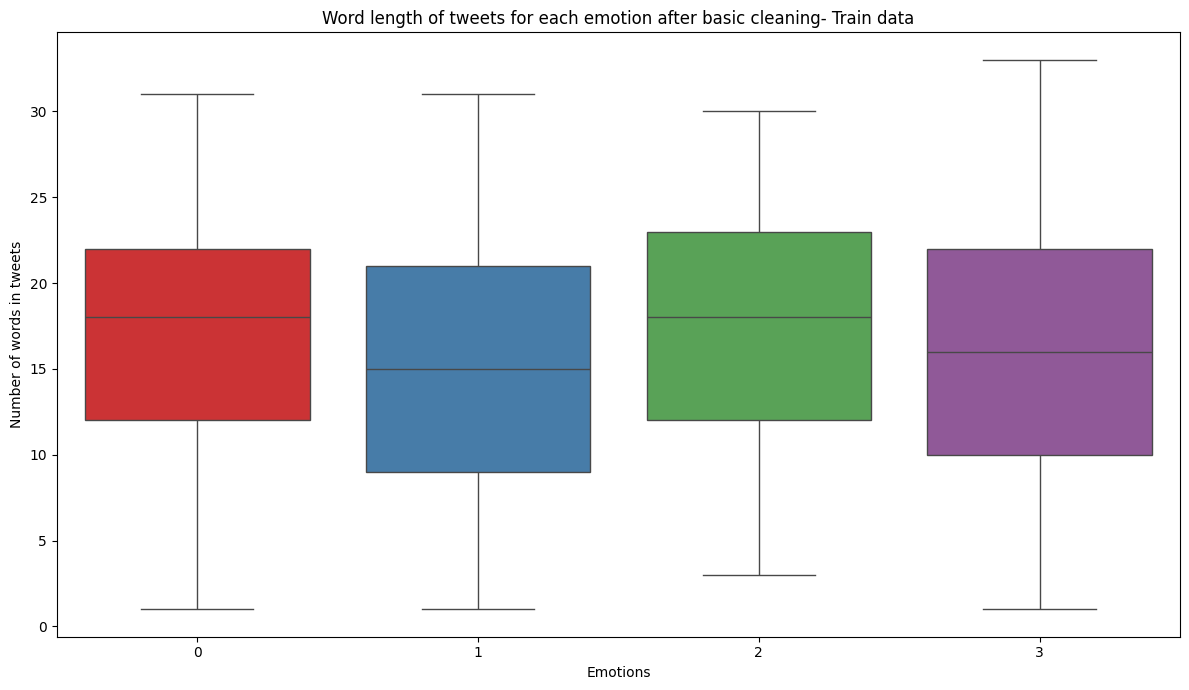

In [32]:
plt.figure(figsize=(12,7))
sns.boxplot(data=train_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- Train data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

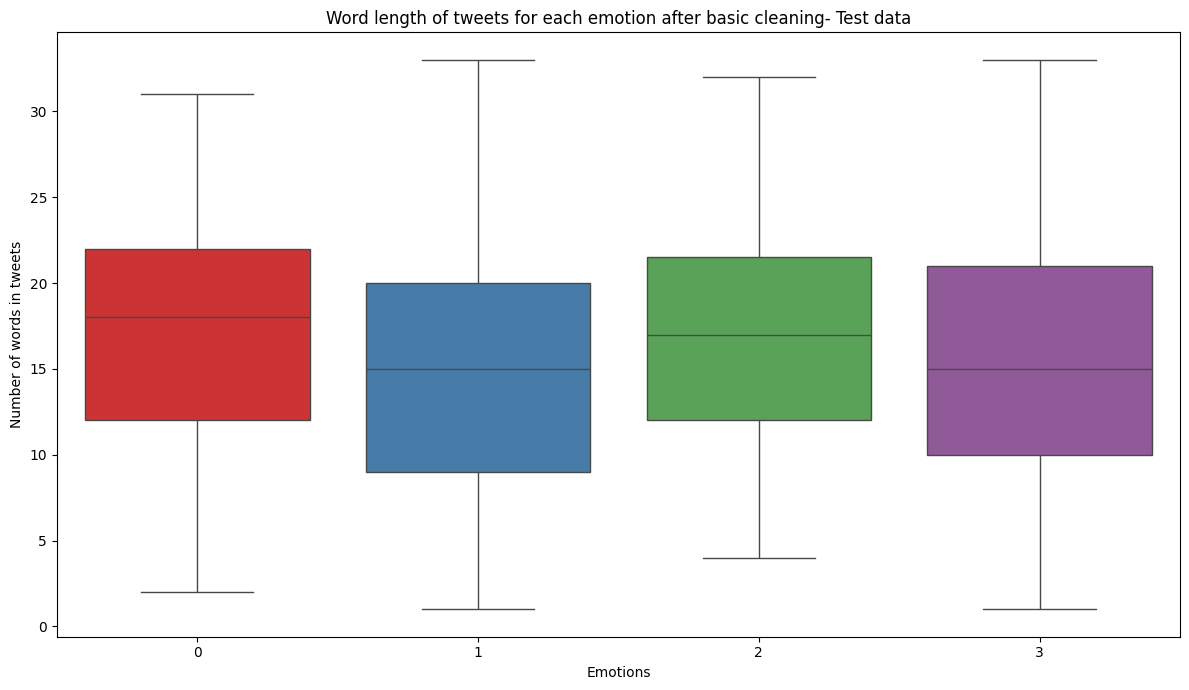

In [33]:
plt.figure(figsize=(12,7))
sns.boxplot(data=test_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- Test data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

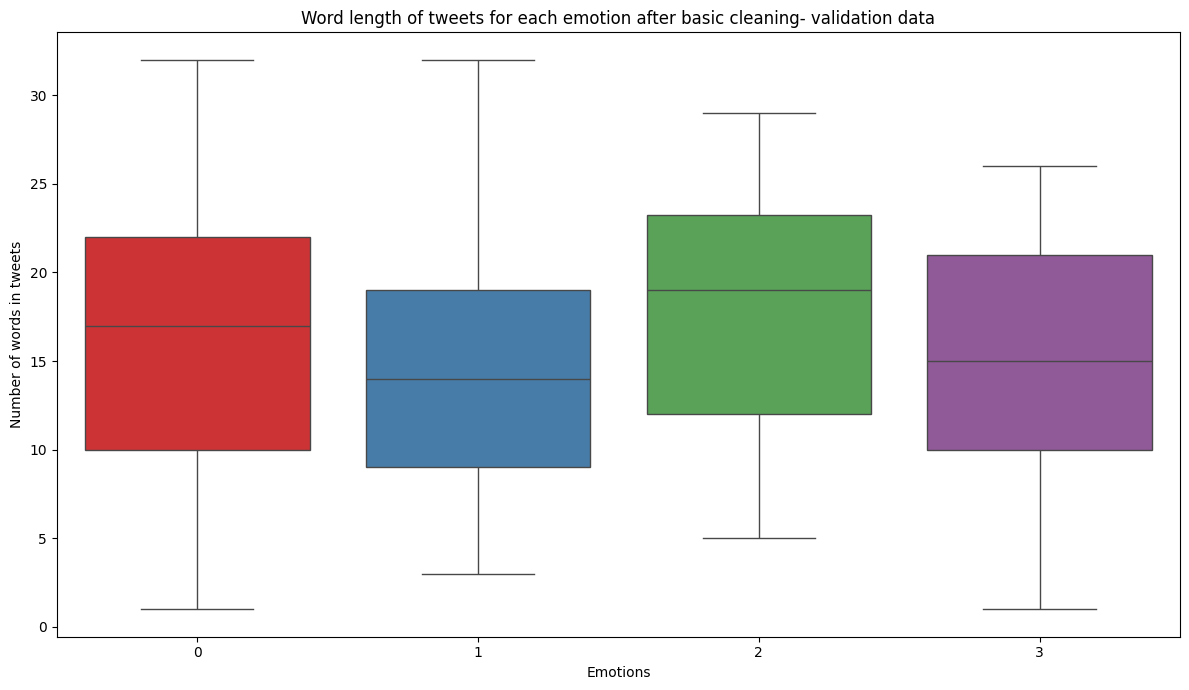

In [34]:
plt.figure(figsize=(12,7))
sns.boxplot(data=validation_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- validation data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

####1. Support Vector Classifier (SVC)

In [35]:
labels_dict = {0:'anger',1: 'joy', 2:'optimism', 3:'sadness'}

In [36]:
train_df_cleaned['label'] = train_df_cleaned['label'].astype('category')
validation_df_cleaned['label'] = validation_df_cleaned['label'].astype('category')
test_df_cleaned['label'] = test_df_cleaned['label'].astype('category')

tfidf_vectorizer = TfidfVectorizer(max_features=16000)
train_features = tfidf_vectorizer.fit_transform(train_df_cleaned['text'])
val_features = tfidf_vectorizer.transform(validation_df_cleaned['text'])
test_features = tfidf_vectorizer.transform(test_df_cleaned['text'])

svc_model = svm.SVC(kernel='linear')
history_svc = svc_model.fit(train_features, train_df_cleaned['label'])

SVC Model - Test Data
               precision    recall  f1-score   support

           0       0.62      0.91      0.73       558
           1       0.72      0.51      0.60       358
           2       0.65      0.21      0.32       123
           3       0.71      0.58      0.64       382

    accuracy                           0.66      1421
   macro avg       0.68      0.55      0.57      1421
weighted avg       0.67      0.66      0.64      1421

Overall Accuracy for SVC - Test data:  0.6579873328641802
Overall F1 score for SVC - Test data:  0.6384775549492574


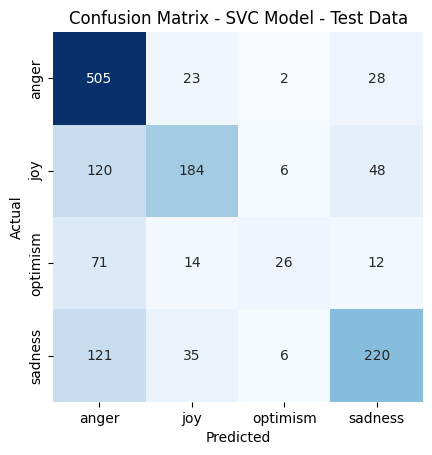

In [37]:
y_test = test_df_cleaned['label']
y_pred = svc_model.predict(test_features)

report = classification_report(y_test, y_pred, target_names=list(labels_dict.keys()), output_dict=True)
print("SVC Model - Test Data\n", classification_report(y_test, y_pred))
print("Overall Accuracy for SVC - Test data: ", accuracy_score(y_test, y_pred))
print("Overall F1 score for SVC - Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC Model - Test Data')
plt.show()

####Bidirectional LSTM

####Tokenization

In [38]:
all_texts = train_df_cleaned['text'].tolist() + test_df_cleaned['text'].tolist() + validation_df_cleaned['text'].tolist()

tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(f"Total Number of words: {len(word_index)}")

# Function to preprocess data with stemming and tokenization
def preprocess_data(data):
    processed_data = []
    for _, row in data.iterrows():
        sequence = tokenizer.texts_to_sequences([row['text'].split()])[0]
        processed_data.append([sequence, row['label']])
    return processed_data

Total Number of words: 11875


In [39]:
train_data_processed = preprocess_data(train_df_cleaned)
val_data_processed = preprocess_data(validation_df_cleaned)

In [40]:
# Separate features and labels, and pad sequences
max_seq_length = max(len(seq[0]) for seq in train_data_processed)
train_X = pad_sequences([row[0] for row in train_data_processed], maxlen=max_seq_length, padding='post')
train_y = np.array([row[1] for row in train_data_processed])
val_X = pad_sequences([row[0] for row in val_data_processed], maxlen=max_seq_length, padding='post')
val_y = np.array([row[1] for row in val_data_processed])

# Convert labels to one-hot encoding
num_classes = 4
train_y_one_hot = to_categorical(train_y, num_classes=num_classes)
val_y_one_hot = to_categorical(val_y, num_classes=num_classes)

print(f"Training set shape: {train_X.shape}, {train_y.shape}")
print(f"Validation set shape: {val_X.shape}, {val_y.shape}")

# Build an optimized bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=16000, output_dim=100, input_length=max_seq_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.001),
    Bidirectional(LSTM(64)),
    Dropout(0.001),
    Dense(num_classes, activation='relu')])

# Compile the model
optimizer = Adam(learning_rate=0.001)
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the model
history_bilstm = model.fit(train_X, train_y_one_hot, epochs=10, validation_data=(val_X, val_y_one_hot), verbose=1)

Training set shape: (3257, 33), (3257,)
Validation set shape: (374, 33), (374,)
Epoch 1/10
102/102 [==============================] - 13s 32ms/step - loss: 1.2506 - balanced_accuracy: 0.4553 - val_loss: 1.1446 - val_balanced_accuracy: 0.5080
Epoch 2/10
102/102 [==============================] - 1s 13ms/step - loss: 0.8026 - balanced_accuracy: 0.6896 - val_loss: 0.9878 - val_balanced_accuracy: 0.6150
Epoch 3/10
102/102 [==============================] - 1s 13ms/step - loss: 0.4482 - balanced_accuracy: 0.8336 - val_loss: 0.9986 - val_balanced_accuracy: 0.6070
Epoch 4/10
102/102 [==============================] - 2s 15ms/step - loss: 0.2791 - balanced_accuracy: 0.9011 - val_loss: 1.1254 - val_balanced_accuracy: 0.5909
Epoch 5/10
102/102 [==============================] - 2s 21ms/step - loss: 0.1649 - balanced_accuracy: 0.9524 - val_loss: 1.5144 - val_balanced_accuracy: 0.5642
Epoch 6/10
102/102 [==============================] - 2s 23ms/step - loss: 0.1040 - balanced_accuracy: 0.9702 - va

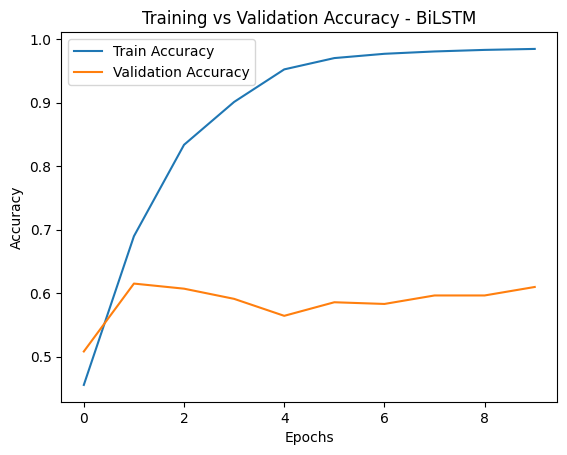

In [41]:
# Plot training and validation accuracy
plt.plot(history_bilstm.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_bilstm.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

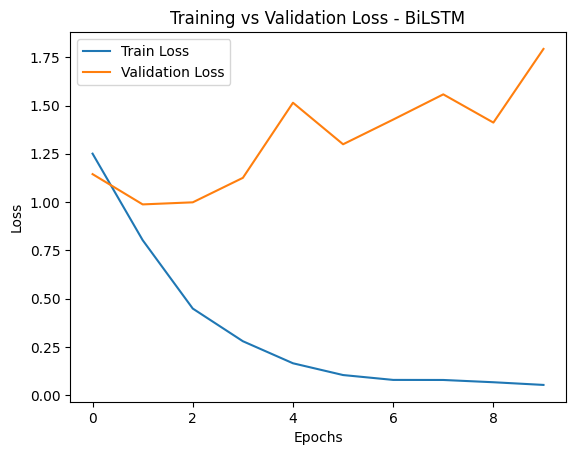

In [42]:
# Plot training and validation loss
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step

Predicted: joy, Actual: joy
1/1 [==============================] - 0s 27ms/step

Predicted: optimism, Actual: anger
1/1 [==============================] - 0s 21ms/step

Predicted: joy, Actual: joy
1/1 [==============================] - 0s 24ms/step

Predicted: anger, Actual: optimism
1/1 [==============================] - 0s 26ms/step

Predicted: anger, Actual: anger
45/45 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       558
           1       0.72      0.44      0.55       358
           2       0.24      0.41      0.30       123
           3       0.62      0.61      0.61       382

    accuracy                           0.61      1421
   macro avg       0.57      0.55      0.55      1421
weighted avg       0.64      0.61      0.61      1421

Overall Accuracy for BiLSTM - Test data:  0.609429978888107
Overall F1 score for BiLSTM - T

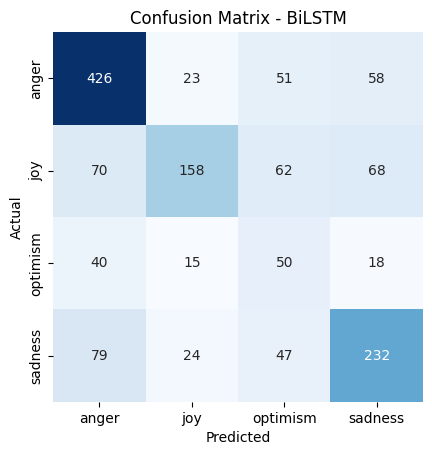

In [43]:
labels_dict = {0:'anger',1: 'joy', 2:'optimism', 3:'sadness'}

# Function to predict on sample test data
def predict_text(text):
  sequence = tokenizer.texts_to_sequences([text])[0]
  sequence_padded = pad_sequences([sequence], maxlen=max_seq_length, padding='post')
  prediction = model.predict(sequence_padded)
  return np.argmax(prediction)

# Random predictions for testing
for _ in range(5):
  index = random.randint(0, len(test_df_cleaned) - 1)
  predicted_class = predict_text(test_df_cleaned['text'][index])
  actual_class = test_df_cleaned['label'][index]
  print(f"\nPredicted: {labels_dict[predicted_class]}, Actual: {labels_dict[actual_class]}")

# Evaluate on entire validation set
test_data_processed = preprocess_data(test_df_cleaned)
test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])
test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

# Predict classes
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(test_y, y_pred_classes, output_dict=True)
print(classification_report(test_y, y_pred_classes))
print("Overall Accuracy for BiLSTM - Test data: ", report["accuracy"])
print("Overall F1 score for BiLSTM - Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(test_y, y_pred_classes)
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BiLSTM')
plt.show()

####3. BERT Model

In [44]:
MAX_LEN=64

In [45]:
#Tokenization
def tokenize(tokenizer, data,max_len=100) :
  input_ids = []
  attention_masks = []
  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
          data[i],
          add_special_tokens=True,
          max_length=max_len,
          padding='max_length',
          return_attention_mask=True
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [46]:
def create_model(custom_model, lr_rate, dec, max_len=MAX_LEN):
  ##params###
  opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_rate, decay=dec)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  accuracy = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

  input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
  embeddings = custom_model(input_ids,attention_masks)[0]
  out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
  out = tf.keras.layers.Dropout(0.001)(out)
  y = Dense(4,activation = 'relu')(out)
  model = tf.keras.models.Model(inputs=[input_ids,attention_masks], outputs=y)
  model.layers[2].trainable = True
  model.compile(opt, loss=loss, metrics=accuracy)
  return model

In [47]:
train_df_cleaned['label'] = train_df_cleaned['label'].astype('category')
validation_df_cleaned['label'] = validation_df_cleaned['label'].astype('category')
test_df_cleaned['label'] = test_df_cleaned['label'].astype('category')

In [48]:
X_train = train_df_cleaned['text'].values
y_train = to_categorical(train_df_cleaned['label'])
X_val = validation_df_cleaned['text'].values
y_val = to_categorical(validation_df_cleaned['label'])
X_test = test_df_cleaned['text'].values
y_test = to_categorical(test_df_cleaned['label'])

In [49]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [50]:
train_input_ids, train_attention_masks = tokenize(bert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(bert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(bert_tokenizer, X_test, MAX_LEN)

In [51]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
model = create_model(bert_model, 1e-5, 1e-7, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 64, 76                                           
                             8),                                                              

In [53]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10


51/51 [==============================] - 65s 864ms/step - loss: 1.3761 - balanced_accuracy: 0.4034 - val_loss: 1.3578 - val_balanced_accuracy: 0.3824
Epoch 2/10
51/51 [==============================] - 40s 786ms/step - loss: 1.3095 - balanced_accuracy: 0.4771 - val_loss: 1.2776 - val_balanced_accuracy: 0.4599
Epoch 3/10
51/51 [==============================] - 40s 794ms/step - loss: 1.1369 - balanced_accuracy: 0.6141 - val_loss: 1.1013 - val_balanced_accuracy: 0.6872
Epoch 4/10
51/51 [==============================] - 41s 813ms/step - loss: 1.0055 - balanced_accuracy: 0.7430 - val_loss: 1.0446 - val_balanced_accuracy: 0.7193
Epoch 5/10
51/51 [==============================] - 42s 826ms/step - loss: 0.8224 - balanced_accuracy: 0.7768 - val_loss: 0.7411 - val_balanced_accuracy: 0.7299
Epoch 6/10
51/51 [==============================] - 43s 844ms/step - loss: 0.4592 - balanced_accuracy: 0.8324 - val_loss: 0.6788 - val_balanced_accuracy: 0.7594
Epoch 7/10
51/51 [===========================

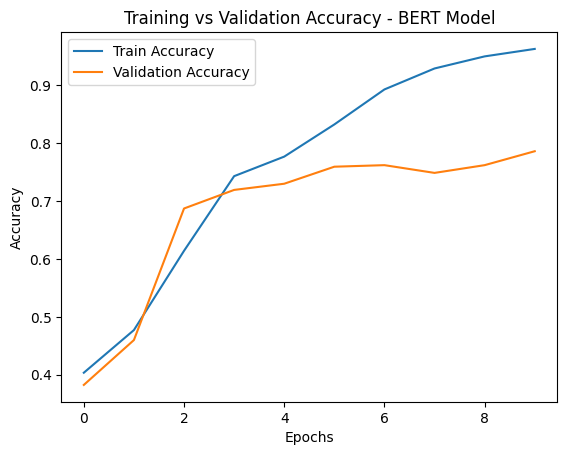

In [54]:
# Plot training and validation accuracy
plt.plot(history_bert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_bert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - BERT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

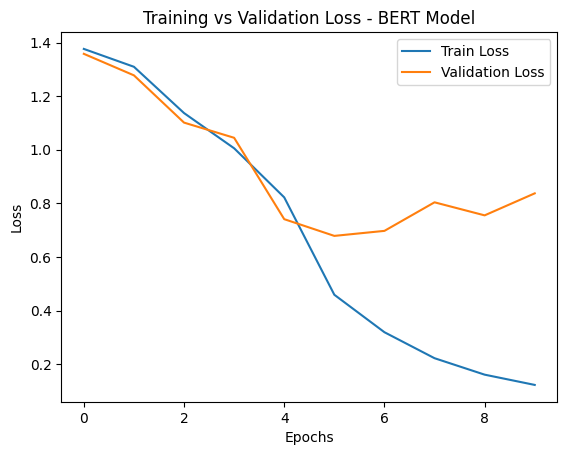

In [55]:
# Plot training and validation loss
plt.plot(history_bert.history['loss'], label='Train Loss')
plt.plot(history_bert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - BERT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 9s 143ms/step
BERT Model - Test Data
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       558
           1       0.86      0.79      0.82       358
           2       0.62      0.51      0.56       123
           3       0.78      0.77      0.77       382

   micro avg       0.80      0.80      0.80      1421
   macro avg       0.77      0.74      0.75      1421
weighted avg       0.80      0.80      0.80      1421
 samples avg       0.80      0.80      0.80      1421

Overall Accuracy for BERT - Test data:  0.7987332864180154
Overall F1 score for Test data - BERT Model:  0.796230237165013


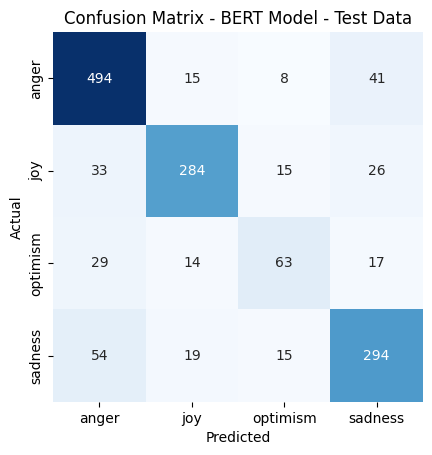

In [56]:
y_pred = model.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("BERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for BERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - BERT Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT Model - Test Data')
plt.show()

####4. Roberta Model

In [57]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [58]:
train_input_ids, train_attention_masks = tokenize(roberta_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(roberta_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(roberta_tokenizer, X_test, MAX_LEN)

In [59]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [60]:
model_roberta = create_model(roberta_model, 1e-5, 1e-7,MAX_LEN)
model_roberta.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [61]:
history_roberta = model_roberta.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10


51/51 [==============================] - 67s 898ms/step - loss: 1.3849 - balanced_accuracy: 0.3826 - val_loss: 1.3632 - val_balanced_accuracy: 0.4840
Epoch 2/10
51/51 [==============================] - 43s 837ms/step - loss: 1.1283 - balanced_accuracy: 0.5812 - val_loss: 0.7743 - val_balanced_accuracy: 0.7246
Epoch 3/10
51/51 [==============================] - 43s 835ms/step - loss: 0.6648 - balanced_accuracy: 0.7504 - val_loss: 0.6209 - val_balanced_accuracy: 0.7540
Epoch 4/10
51/51 [==============================] - 44s 856ms/step - loss: 0.5221 - balanced_accuracy: 0.7931 - val_loss: 0.6676 - val_balanced_accuracy: 0.7460
Epoch 5/10
51/51 [==============================] - 44s 858ms/step - loss: 0.4400 - balanced_accuracy: 0.8198 - val_loss: 0.6208 - val_balanced_accuracy: 0.7567
Epoch 6/10
51/51 [==============================] - 44s 855ms/step - loss: 0.3928 - balanced_accuracy: 0.8324 - val_loss: 0.6363 - val_balanced_accuracy: 0.7513
Epoch 7/10
51/51 [===========================

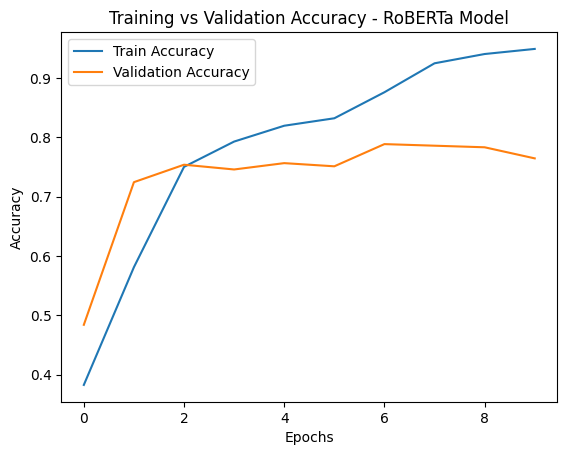

In [62]:
# Plot training and validation accuracy
plt.plot(history_roberta.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_roberta.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - RoBERTa Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

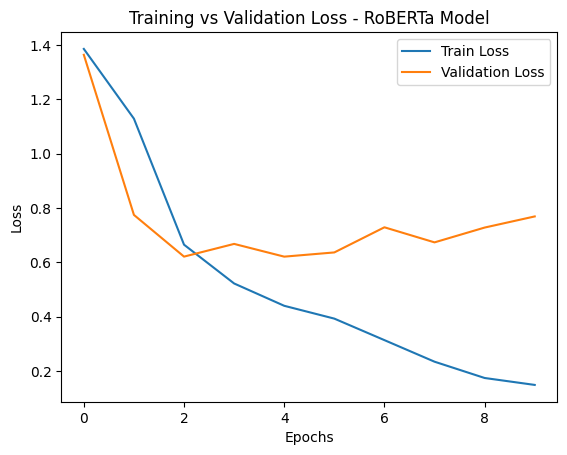

In [63]:
# Plot training and validation loss
plt.plot(history_roberta.history['loss'], label='Train Loss')
plt.plot(history_roberta.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - RoBERTa Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 9s 138ms/step
RoBERTa Model - Test Data
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       558
           1       0.86      0.77      0.81       358
           2       0.63      0.62      0.63       123
           3       0.79      0.77      0.78       382

   micro avg       0.80      0.80      0.80      1421
   macro avg       0.77      0.76      0.77      1421
weighted avg       0.80      0.80      0.80      1421
 samples avg       0.80      0.80      0.80      1421

Overall Accuracy for RoBERTa - Test data:  0.800844475721323
Overall F1 score for Test data - RoBERTa Model:  0.7999290605165946


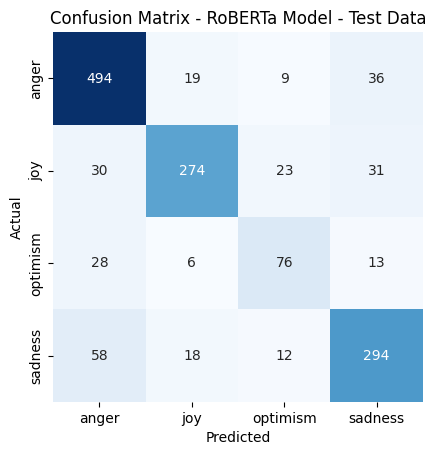

In [64]:
y_pred = model_roberta.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("RoBERTa Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for RoBERTa - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - RoBERTa Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RoBERTa Model - Test Data')
plt.show()

####5. DistilBert Model

In [111]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [112]:
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer, X_test, MAX_LEN)

In [113]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [114]:
model_distilbert = create_model(distilbert_model, 1e-5, 1e-7, MAX_LEN)

In [115]:
model_distilbert.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_5 (TF  TFBaseModelOutput(last_hid   6636288   ['input_19[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_20[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [116]:
history_distilbert = model_distilbert.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10
88/88 [==============================] - 46s 416ms/step - loss: 1.2232 - balanced_accuracy: 0.4448 - val_loss: 0.9075 - val_balanced_accuracy: 0.6631
Epoch 2/10
88/88 [==============================] - 35s 403ms/step - loss: 0.6070 - balanced_accuracy: 0.7855 - val_loss: 0.6965 - val_balanced_accuracy: 0.7273
Epoch 3/10
88/88 [==============================] - 36s 408ms/step - loss: 0.3514 - balanced_accuracy: 0.8827 - val_loss: 0.7134 - val_balanced_accuracy: 0.7380
Epoch 4/10
88/88 [==============================] - 36s 407ms/step - loss: 0.2131 - balanced_accuracy: 0.9334 - val_loss: 0.7559 - val_balanced_accuracy: 0.7299
Epoch 5/10
88/88 [==============================] - 37s 416ms/step - loss: 0.1370 - balanced_accuracy: 0.9586 - val_loss: 0.7968 - val_balanced_accuracy: 0.7540
Epoch 6/10
88/88 [==============================] - 36s 411ms/step - loss: 0.0910 - balanced_accuracy: 0.9754 - val_loss: 0.8310 - val_balanced_accuracy: 0.7487
Epoch 7/10
88/88 [================

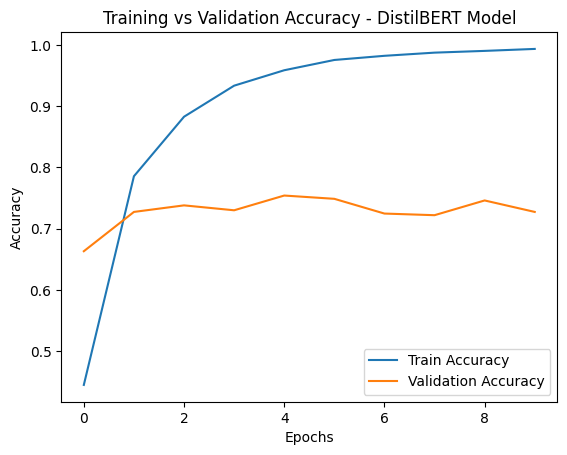

In [117]:
# Plot training and validation accuracy
plt.plot(history_distilbert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

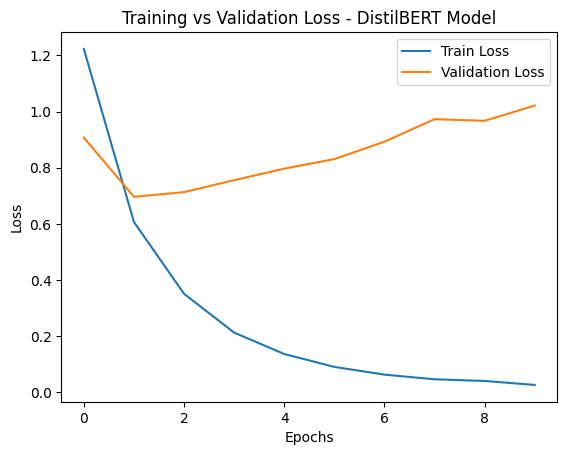

In [118]:
# Plot training and validation loss
plt.plot(history_distilbert.history['loss'], label='Train Loss')
plt.plot(history_distilbert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 5s 70ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       558
           1       0.81      0.80      0.81       358
           2       0.61      0.64      0.63       123
           3       0.71      0.80      0.75       382

   micro avg       0.78      0.78      0.78      1421
   macro avg       0.75      0.76      0.75      1421
weighted avg       0.79      0.78      0.78      1421
 samples avg       0.78      0.78      0.78      1421

Overall Accuracy for DistilBERT - Test data:  0.7804363124560169
Overall F1 score for Test data - DistilBERT Model:  0.7820363510800009


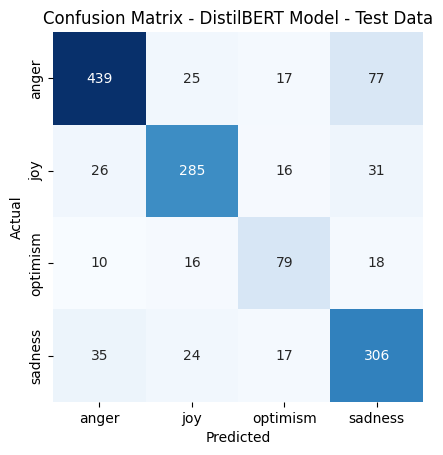

In [119]:
y_pred = model_distilbert.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - DistilBERT Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model - Test Data')
plt.show()

####Oversampling - Treating imbalance in the training data

In [103]:
train_x, train_y = RandomOverSampler().fit_resample(np.array(train_df_cleaned['text']).reshape(-1, 1), np.array(train_df_cleaned['label']).reshape(-1, 1))
train_os_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'label'])

In [104]:
X_train = train_os_df['text'].values
y_train = to_categorical(train_os_df['label'])
X_val = validation_df_cleaned['text'].values
y_val = to_categorical(validation_df_cleaned['label'])
X_test = test_df_cleaned['text'].values
y_test = to_categorical(test_df_cleaned['label'])
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer, X_test, MAX_LEN)

In [105]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model_distilbert = create_model(distilbert_model, 1e-5, 1e-7, MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [106]:
model_distilbert.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_4 (TF  TFBaseModelOutput(last_hid   6636288   ['input_17[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_18[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [107]:
history_distilbert = model_distilbert.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10
88/88 [==============================] - 47s 388ms/step - loss: 1.3853 - balanced_accuracy: 0.2489 - val_loss: 1.2841 - val_balanced_accuracy: 0.4278
Epoch 2/10
88/88 [==============================] - 34s 386ms/step - loss: 1.2467 - balanced_accuracy: 0.2514 - val_loss: 1.0600 - val_balanced_accuracy: 0.4278
Epoch 3/10
88/88 [==============================] - 34s 387ms/step - loss: 1.1483 - balanced_accuracy: 0.2543 - val_loss: 1.0705 - val_balanced_accuracy: 0.4305
Epoch 4/10
88/88 [==============================] - 36s 406ms/step - loss: 0.9462 - balanced_accuracy: 0.4893 - val_loss: 0.8985 - val_balanced_accuracy: 0.5802
Epoch 5/10
88/88 [==============================] - 36s 407ms/step - loss: 0.5792 - balanced_accuracy: 0.7282 - val_loss: 0.7734 - val_balanced_accuracy: 0.7326
Epoch 6/10
88/88 [==============================] - 36s 412ms/step - loss: 0.2332 - balanced_accuracy: 0.9320 - val_loss: 0.8232 - val_balanced_accuracy: 0.7353
Epoch 7/10
88/88 [================

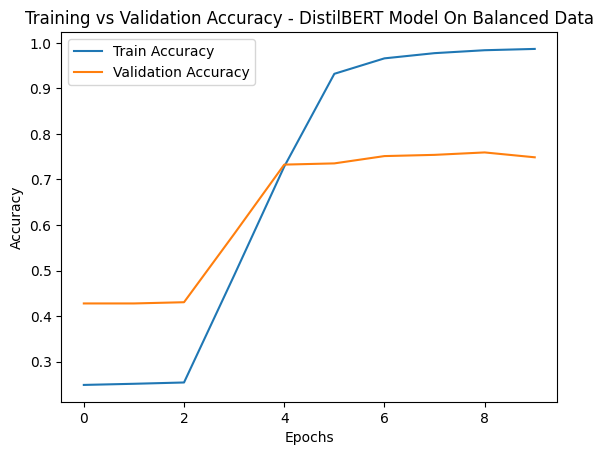

In [108]:
# Plot training and validation accuracy
plt.plot(history_distilbert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model On Balanced Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

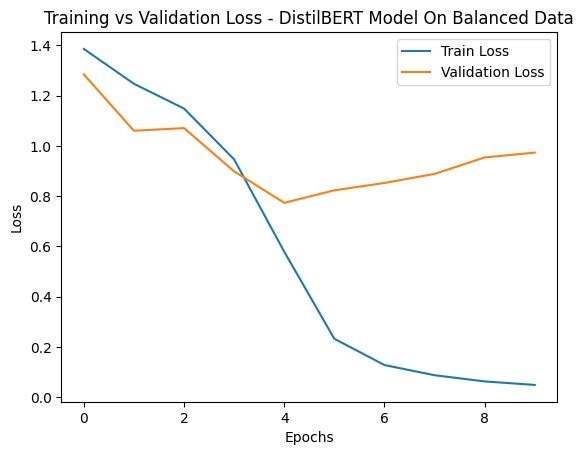

In [109]:
# Plot training and validation loss
plt.plot(history_distilbert.history['loss'], label='Train Loss')
plt.plot(history_distilbert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model On Balanced Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 6s 74ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.88      0.80      0.83       558
           1       0.78      0.81      0.80       358
           2       0.62      0.53      0.57       123
           3       0.71      0.82      0.76       382

   micro avg       0.78      0.78      0.78      1421
   macro avg       0.75      0.74      0.74      1421
weighted avg       0.79      0.78      0.78      1421
 samples avg       0.78      0.78      0.78      1421

Overall Accuracy for DistilBERT (Balanced Train Data)- Test data:  0.7825475017593244
Overall F1 score for DistilBERT Model (Balanced Train Data)- Test data:  0.7824887138329641


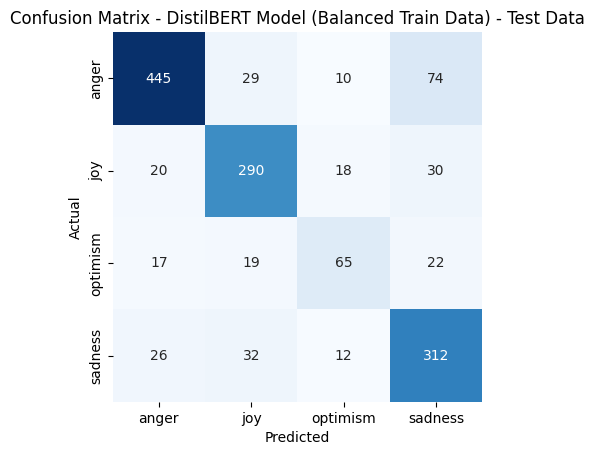

In [110]:
y_pred = model_distilbert.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT (Balanced Train Data)- Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for DistilBERT Model (Balanced Train Data)- Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model (Balanced Train Data) - Test Data')
plt.show()

####Fine tuning

####Roberta

In [95]:
roberta_tokenizer_tuned = RobertaTokenizerFast.from_pretrained("roberta-base")

In [96]:
train_input_ids, train_attention_masks = tokenize(roberta_tokenizer_tuned, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(roberta_tokenizer_tuned, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(roberta_tokenizer_tuned, X_test, MAX_LEN)
roberta_model_tuned = TFRobertaModel.from_pretrained('roberta-base')
model_roberta_tuned = create_model(roberta_model_tuned, 8e-5, 1e-7, MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [97]:
model_roberta_tuned.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_roberta_model_2 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_15[0][0]',            
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_16[0][0]']            
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [98]:
history_roberta_tuned = model_roberta_tuned.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=15, batch_size=64)

Epoch 1/15


51/51 [==============================] - 63s 863ms/step - loss: 1.0497 - balanced_accuracy: 0.5278 - val_loss: 0.8243 - val_balanced_accuracy: 0.5936
Epoch 2/15
51/51 [==============================] - 42s 817ms/step - loss: 0.8278 - balanced_accuracy: 0.5889 - val_loss: 0.8231 - val_balanced_accuracy: 0.5695
Epoch 3/15
51/51 [==============================] - 41s 813ms/step - loss: 0.6206 - balanced_accuracy: 0.7338 - val_loss: 0.6596 - val_balanced_accuracy: 0.7460
Epoch 4/15
51/51 [==============================] - 42s 825ms/step - loss: 0.4643 - balanced_accuracy: 0.8084 - val_loss: 0.6142 - val_balanced_accuracy: 0.7701
Epoch 5/15
51/51 [==============================] - 43s 849ms/step - loss: 0.3488 - balanced_accuracy: 0.8440 - val_loss: 0.6795 - val_balanced_accuracy: 0.7406
Epoch 6/15
51/51 [==============================] - 43s 853ms/step - loss: 0.2911 - balanced_accuracy: 0.8597 - val_loss: 0.6353 - val_balanced_accuracy: 0.7727
Epoch 7/15
51/51 [===========================

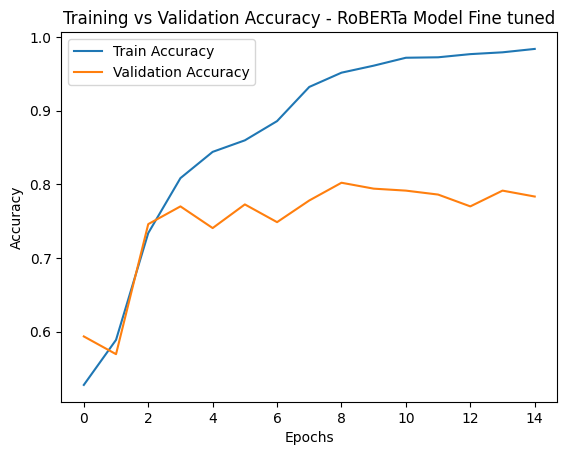

In [99]:
# Plot training and validation accuracy
plt.plot(history_roberta_tuned.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_roberta_tuned.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - RoBERTa Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

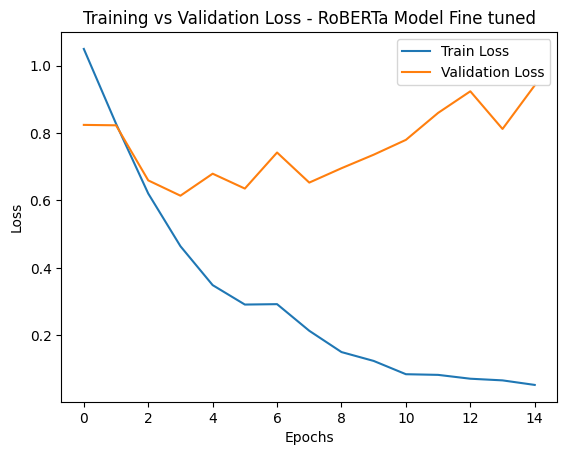

In [100]:
# Plot training and validation loss
plt.plot(history_roberta_tuned.history['loss'], label='Train Loss')
plt.plot(history_roberta_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - RoBERTa Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 9s 138ms/step
RoBERTa Model - Test Data
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       558
           1       0.79      0.84      0.82       358
           2       0.68      0.64      0.66       123
           3       0.76      0.78      0.77       382

   micro avg       0.80      0.80      0.80      1421
   macro avg       0.77      0.77      0.77      1421
weighted avg       0.80      0.80      0.80      1421
 samples avg       0.80      0.80      0.80      1421

Overall Accuracy for RoBERTa - Test data:  0.8015482054890922
Overall F1 score for Test data - RoBERTa Model Fine tuned:  0.8015138993914757


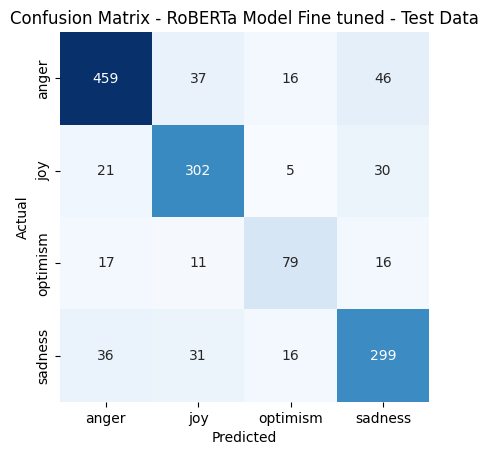

In [101]:
y_pred = model_roberta_tuned.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("RoBERTa Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for RoBERTa - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - RoBERTa Model Fine tuned: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RoBERTa Model Fine tuned - Test Data')
plt.show()

####DistilBERT Model

In [88]:
distilbert_tokenizer_tuned = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [89]:
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer_tuned, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer_tuned, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer_tuned, X_test, MAX_LEN)
distilbert_model_tuned = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model_distilbert_tuned = create_model(distilbert_model_tuned, 1e-5, 1e-8, MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [90]:
model_distilbert_tuned.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_3 (TF  TFBaseModelOutput(last_hid   6636288   ['input_13[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_14[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [91]:
history_distilbert_tuned = model_distilbert_tuned.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=12, batch_size=64)

Epoch 1/12
51/51 [==============================] - 34s 473ms/step - loss: 1.2457 - balanced_accuracy: 0.4538 - val_loss: 1.1193 - val_balanced_accuracy: 0.5294
Epoch 2/12
51/51 [==============================] - 21s 410ms/step - loss: 0.9855 - balanced_accuracy: 0.5686 - val_loss: 0.9169 - val_balanced_accuracy: 0.6283
Epoch 3/12
51/51 [==============================] - 21s 416ms/step - loss: 0.7042 - balanced_accuracy: 0.7313 - val_loss: 0.6986 - val_balanced_accuracy: 0.7460
Epoch 4/12
51/51 [==============================] - 21s 409ms/step - loss: 0.4977 - balanced_accuracy: 0.8182 - val_loss: 0.6466 - val_balanced_accuracy: 0.7594
Epoch 5/12
51/51 [==============================] - 21s 422ms/step - loss: 0.3753 - balanced_accuracy: 0.8692 - val_loss: 0.6397 - val_balanced_accuracy: 0.7594
Epoch 6/12
51/51 [==============================] - 21s 415ms/step - loss: 0.2996 - balanced_accuracy: 0.8968 - val_loss: 0.6783 - val_balanced_accuracy: 0.7406
Epoch 7/12
51/51 [================

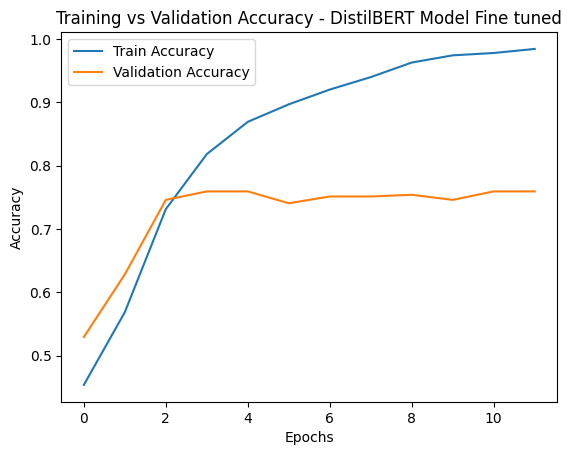

In [92]:
# Plot training and validation accuracy
plt.plot(history_distilbert_tuned.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert_tuned.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

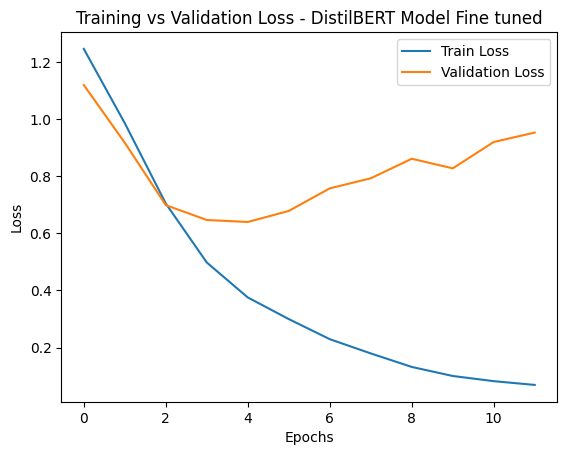

In [93]:
# Plot training and validation loss
plt.plot(history_distilbert_tuned.history['loss'], label='Train Loss')
plt.plot(history_distilbert_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 5s 70ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       558
           1       0.84      0.80      0.82       358
           2       0.64      0.46      0.54       123
           3       0.77      0.79      0.78       382

   micro avg       0.80      0.80      0.80      1421
   macro avg       0.76      0.73      0.74      1421
weighted avg       0.79      0.80      0.79      1421
 samples avg       0.80      0.80      0.80      1421

Overall Accuracy for DistilBERT - Test data:  0.7952146375791695
Overall F1 score for Test data - DistilBERT Model Fine tuned:  0.7917069605466314


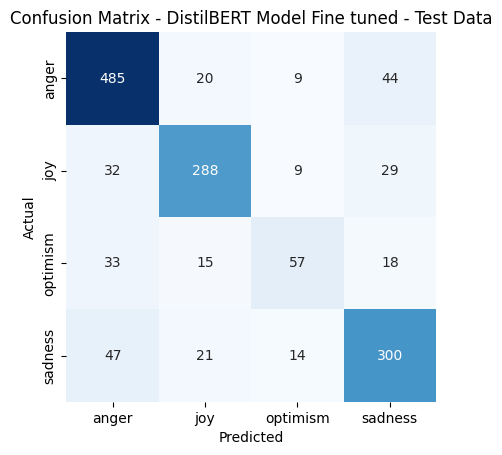

In [94]:
y_pred = model_distilbert_tuned.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - DistilBERT Model Fine tuned: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model Fine tuned - Test Data')
plt.show()

####Prediction for Custom Tweet Text

In [124]:
def custom_text_cleaning(custom_text):
  text = str(custom_text).lower()
  text = th.cont_exp(text)
  text = th.remove_emails(text)
  text = th.remove_html_tags(text)
  text = th.remove_special_chars(text)
  text = th.remove_accented_chars(text)
  return text

In [165]:
def get_prediction(text, model, tokenizer):
  clean_text = custom_text_cleaning(text)
  test_input_ids, test_attention_masks = tokenize(tokenizer, [clean_text], 64)
  y_pred = model.predict([test_input_ids,test_attention_masks])
  y_pred_classes =  np.zeros_like(y_pred)
  y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1
  if y_pred_classes[0][1] == 1:
    emotion = 'joy'
  elif y_pred_classes[0][2] == 1:
    emotion = 'optimism'
  elif y_pred_classes[0][3] == 1:
    emotion = 'sadness'
  elif y_pred_classes[0][0] == 1:
    emotion = 'anger'

  return {
      'cleaned text': clean_text,
      'emotion': emotion,
      'label': list(labels_dict.keys())[list(labels_dict.values()).index(emotion)]
  }

In [166]:
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:it was quite unfortunate and devastated to hear about the news#####ddishearteing @#11
1/1 [==============================] - 0s 39ms/step
{'cleaned text': 'it was quite unfortunate and devastated to hear about the newsddishearteing 11', 'emotion': 'sadness', 'label': 3}


In [167]:
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:@user @user USA was embarrassing to watch. When was the last time you guys won a game..? #horrible #joke
1/1 [==============================] - 0s 140ms/step
{'cleaned text': 'user user usa was embarrassing to watch when was the last time you guys won a game horrible joke', 'emotion': 'anger', 'label': 0}


In [172]:
#Angry tweets
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still...
1/1 [==============================] - 0s 40ms/step
{'cleaned text': 'user interesting choice of words are you confirming that governments fund terrorism bit of an open door but still', 'emotion': 'anger', 'label': 0}


In [169]:
#Real life data - funny tweets - Correct prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:when i was like 5 my best friend’s and my favorite game to play was “mary kate and ashley” which was basically just hanging out like normal but calling each other mary kate and ashley
1/1 [==============================] - 0s 74ms/step
{'cleaned text': 'when i was like 5 my best friends and my favorite game to play was mary kate and ashley which was basically just hanging out like normal but calling each other mary kate and ashley', 'emotion': 'joy', 'label': 1}


In [168]:
#Real life data - funny tweets - wrong prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:Met a dog at the dog park named Gumball and it completely changed my mood. You can’t meet a dog named Gumball and be a miserable asshole.
1/1 [==============================] - 0s 67ms/step
{'cleaned text': 'met a dog at the dog park named gumball and it completely changed my mood you cant meet a dog named gumball and be a miserable asshole', 'emotion': 'anger', 'label': 0}


In [171]:
#Real life data - optimistic tweets - Correct prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:This is Jake. Jake stays positive and focuses on the good—even in challenging times. Be like Jake.
1/1 [==============================] - 0s 66ms/step
{'cleaned text': 'this is jake jake stays positive and focuses on the goodeven in challenging times be like jake', 'emotion': 'optimism', 'label': 2}


In [170]:
#Real life data - optimistic tweets - wrong prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:"The real power in kindness is that when you practice it, it rubs off on others and cause an incredible ripple effect." -  @Aly_Raisman
1/1 [==============================] - 0s 42ms/step
{'cleaned text': 'the real power in kindness is that when you practice it it rubs off on others and cause an incredible ripple effect aly_raisman', 'emotion': 'joy', 'label': 1}


In [173]:
#Real life sad tweets - Correct prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:i reallyyy miss talking to you but i just need to accept it........
1/1 [==============================] - 0s 39ms/step
{'cleaned text': 'i reallyyy miss talking to you but i just need to accept it', 'emotion': 'sadness', 'label': 3}


In [174]:
#Real life anger tweets - Correct prediction
usr_input = input("Enter your tweet:")
print(get_prediction(usr_input, model_distilbert_tuned, distilbert_tokenizer_tuned))

Enter your tweet:THE RIGGED AND CORRUPT MEDIA IS THE ENEMY OF THE PEOPLE
1/1 [==============================] - 0s 43ms/step
{'cleaned text': 'the rigged and corrupt media is the enemy of the people', 'emotion': 'anger', 'label': 0}


######Proposed Final Model - Tuned DistilBERT model with following hyperparameters:
•	learning_rate: 1e-5\
•	batch_size: 64\
•	decay: 1e-8\
•	optimizer: Adam\
•	epochs: 12

Test Data Results:
1. F1 score: 0.7917
2. Accuracy: 0.7952

There are two major observations and conclusions:
1. There is not much of a difference in the DistilBERT model performance considering balanced vs imbalanced training data. Hence, the approach of oversampling to treat imbalance was dropped and proceeded with fine tuning RoBERTa and DistilBERT considering the original imbalanced dataset.
2. It can be seen that fine-tuned RoBERTa model has slightly better weighted F1 score(0.8015) and accuracy score(0.8015). However, the final proposed model for the given dataset has been decided as the fine-tuned distilBERT model (weighted F1 score 0.7917 and accuracy - 0.7952) considering the factor of Total params, which is only 66365956 (253.17 MB) for distilBERT while it is 124648708 (475.50 MB) about twice as distilBERT model. Hence DistilBERT model with the above hyperparameters is the final model which performs equivalent to RoBERTa/BERT model but is much light-weight, efficient and faster which makes it computationally efficient option to choose for the given twitter dataset where the length of text is also not large in size. Here, the maximum tweet length without removing stop words was only 33.
